Batches: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


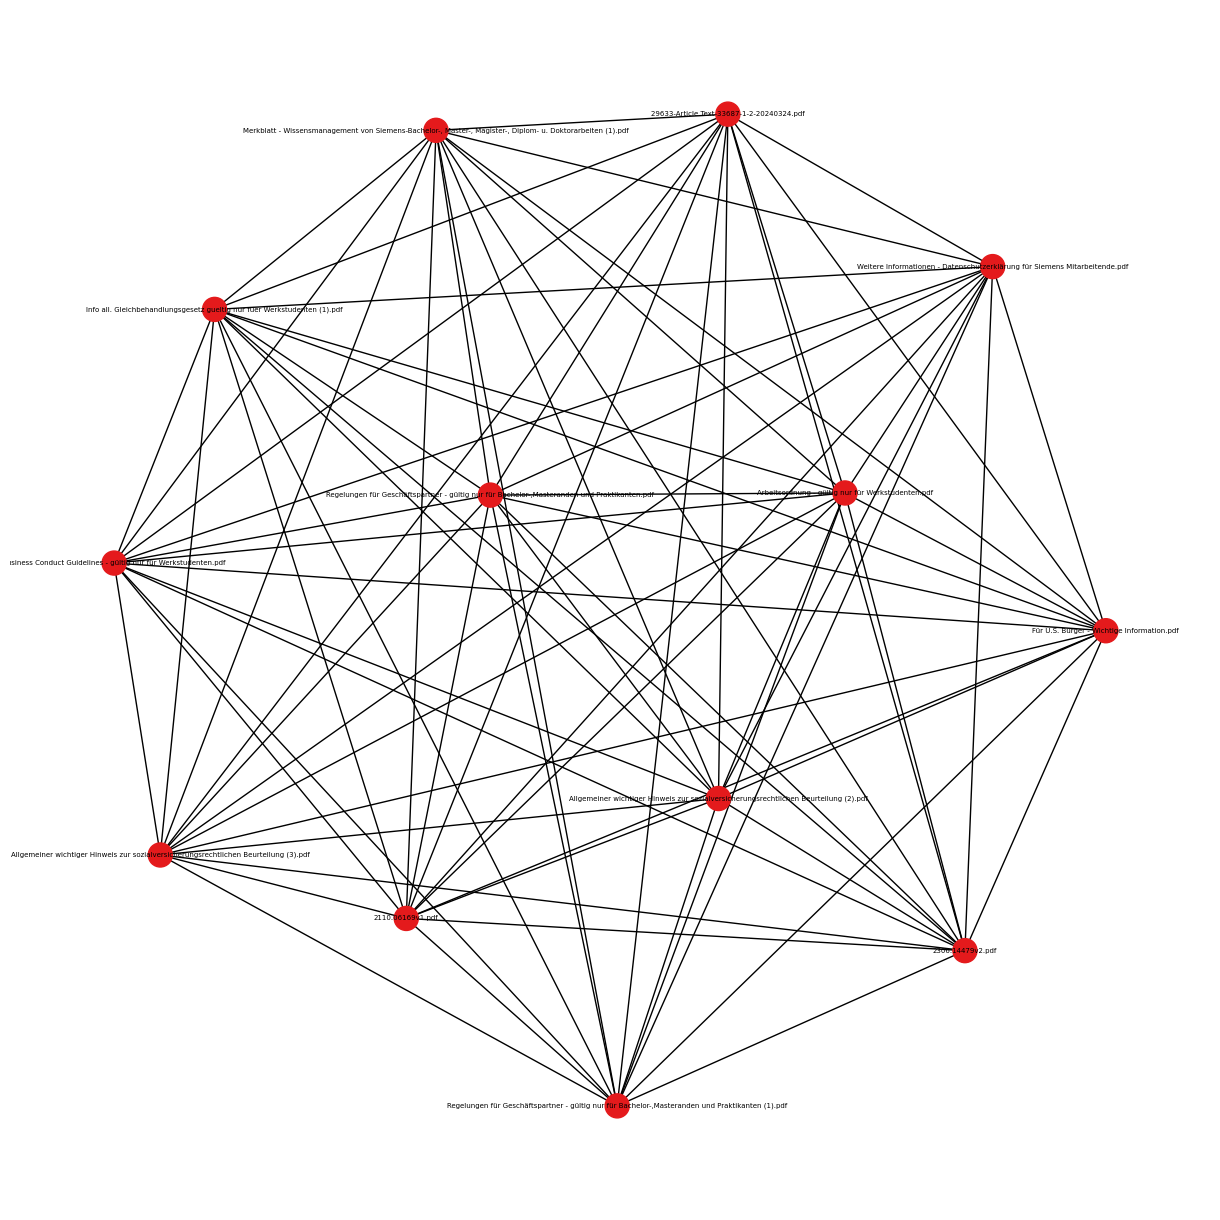

c:\Users\batik\miniconda3\envs\0General\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


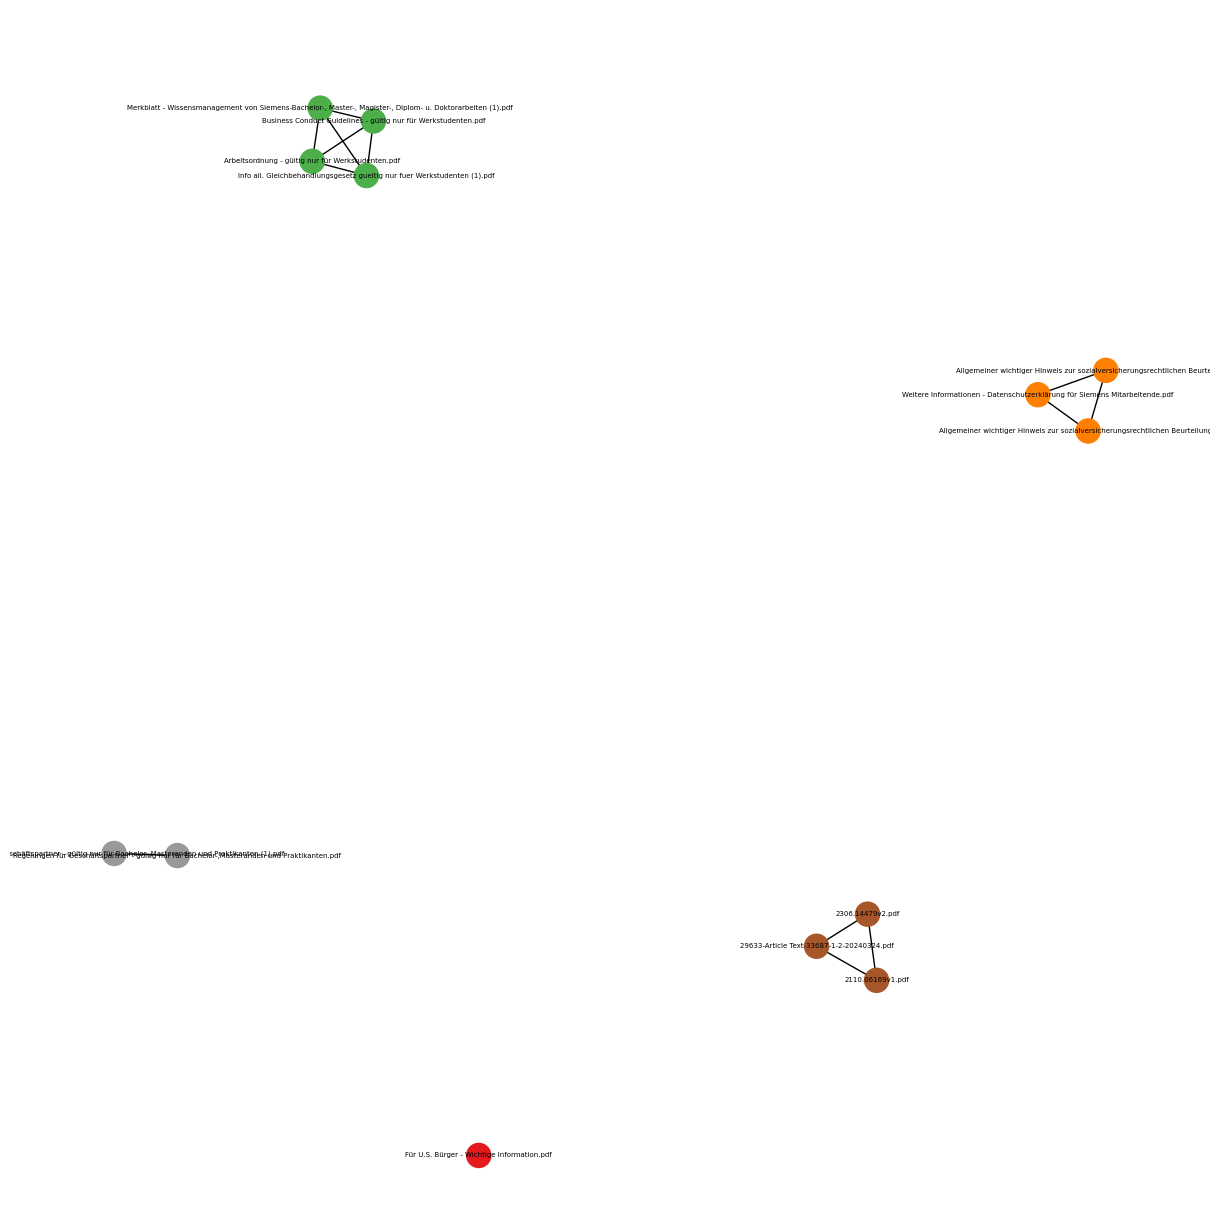

c:\Users\batik\miniconda3\envs\0General\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


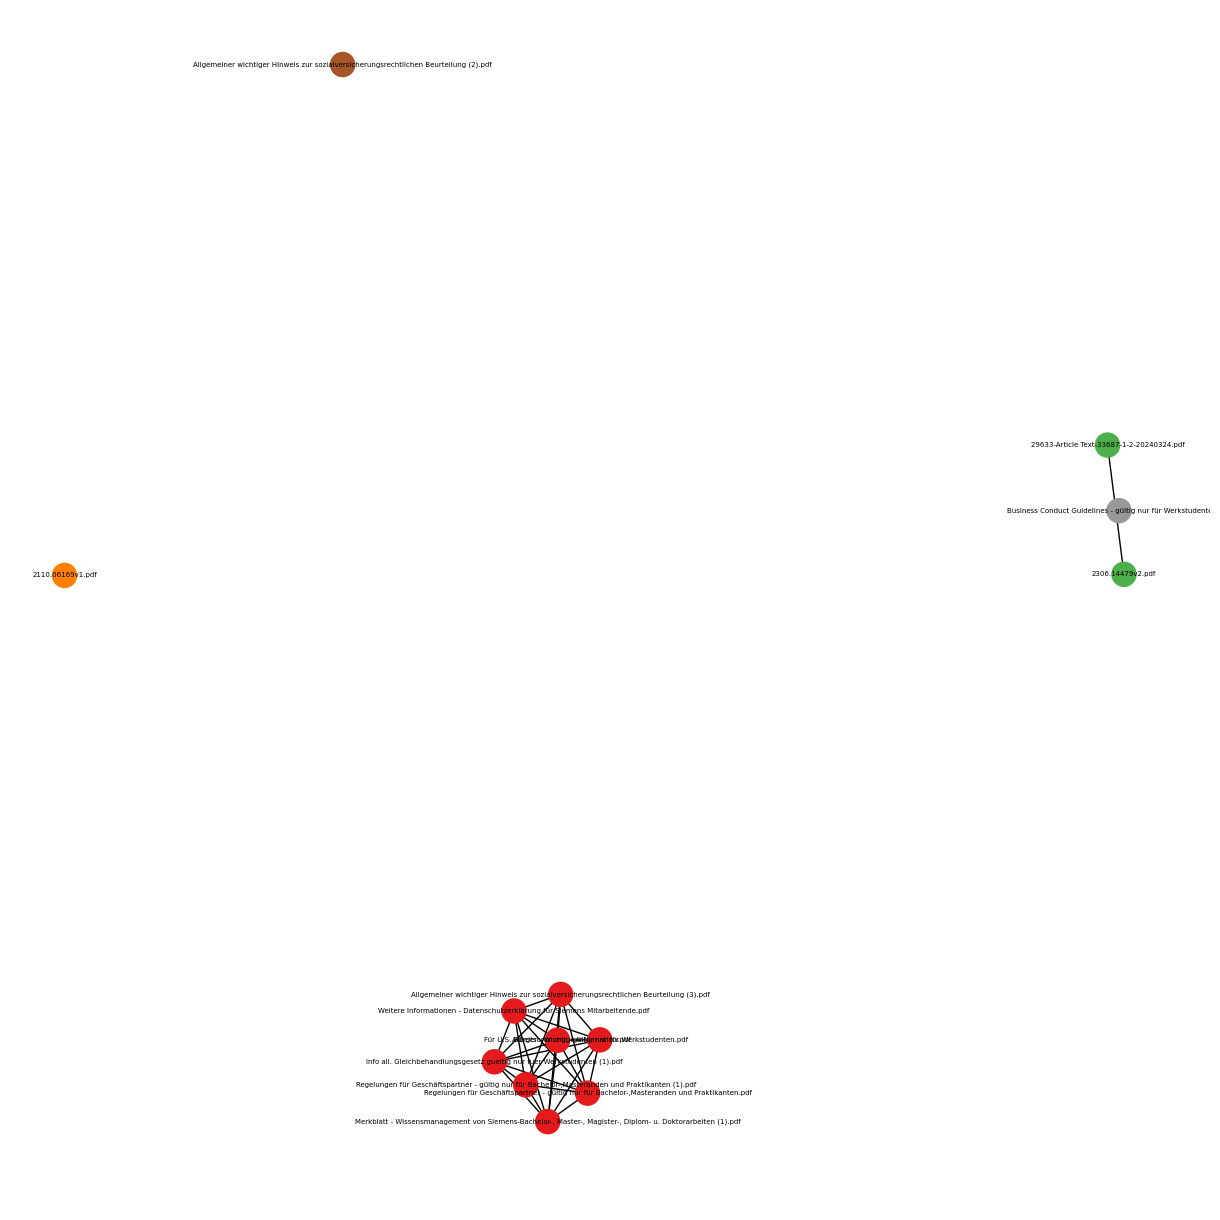

c:\Users\batik\miniconda3\envs\0General\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


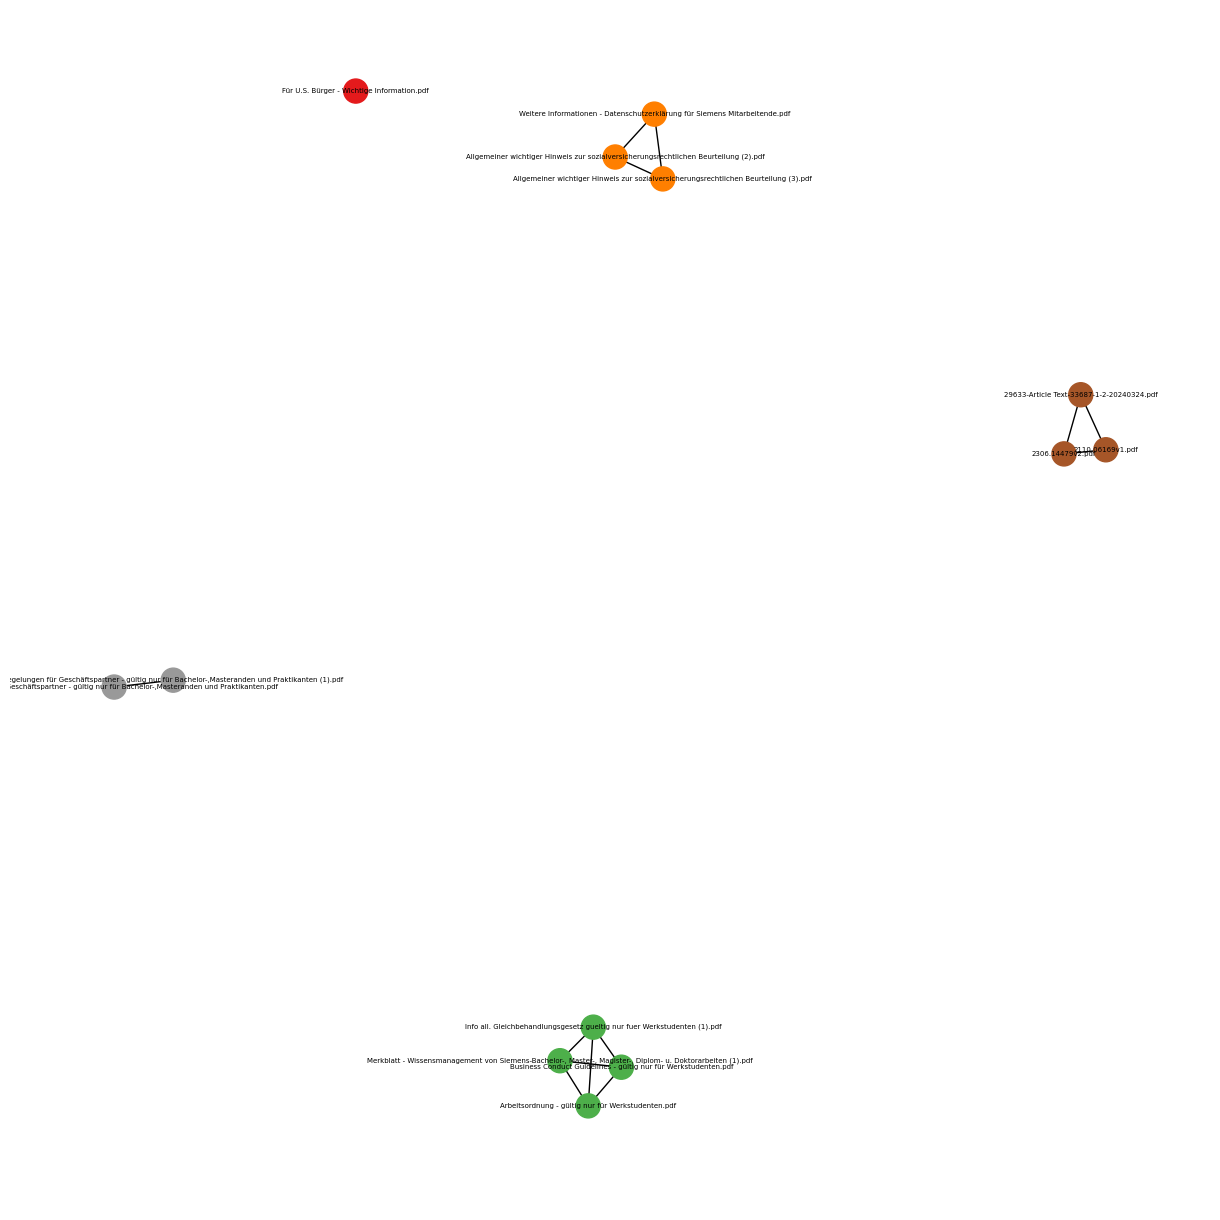

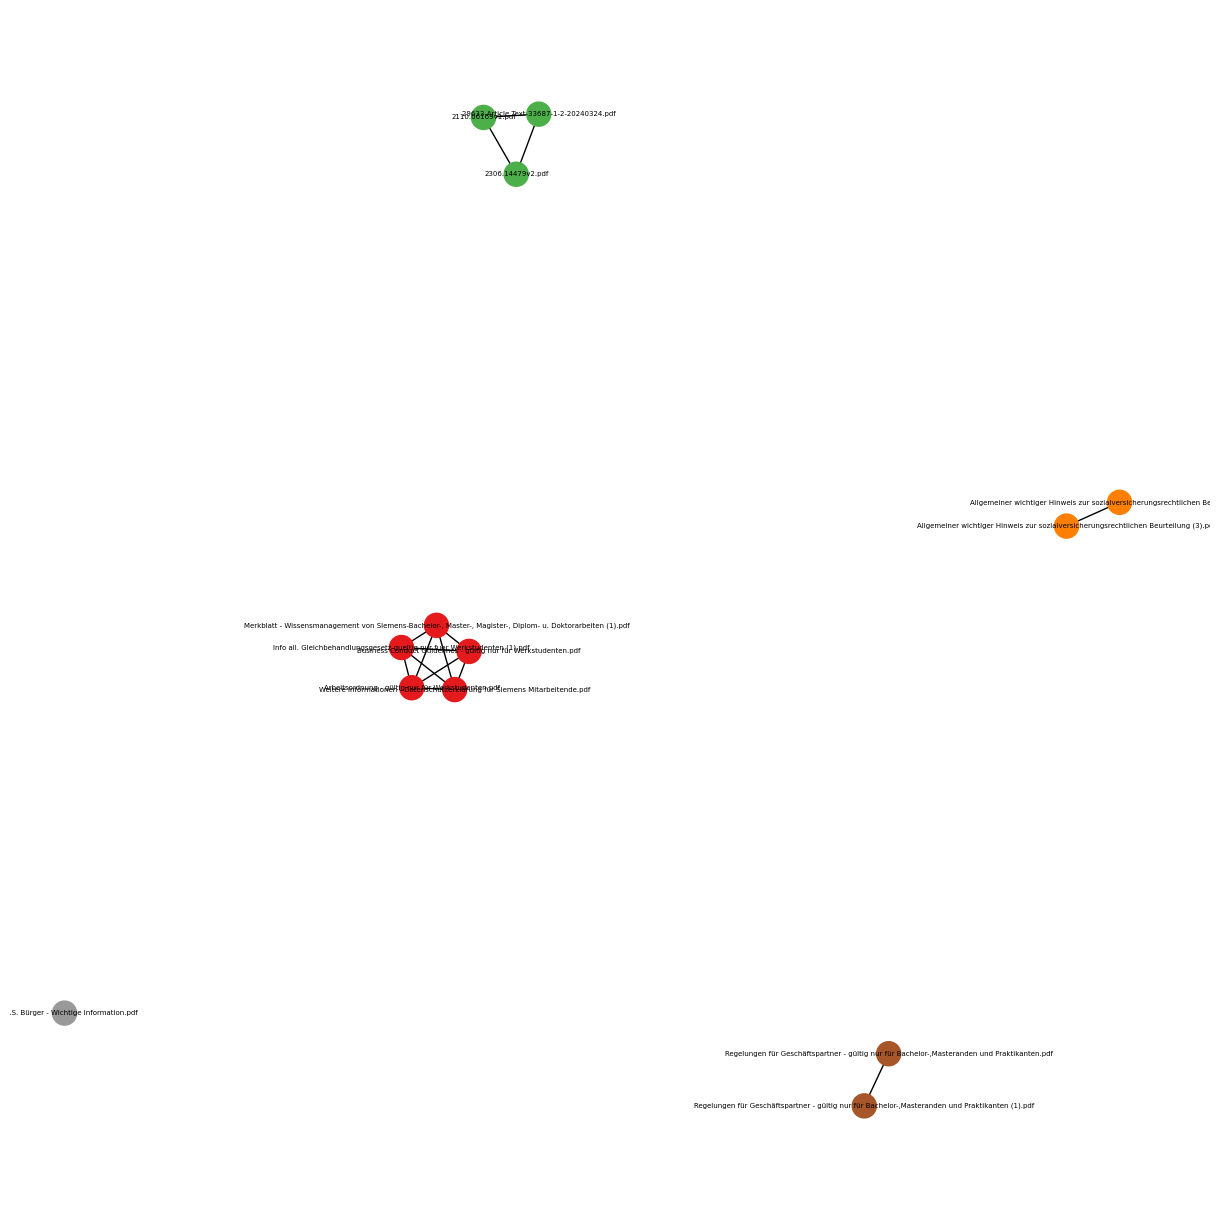

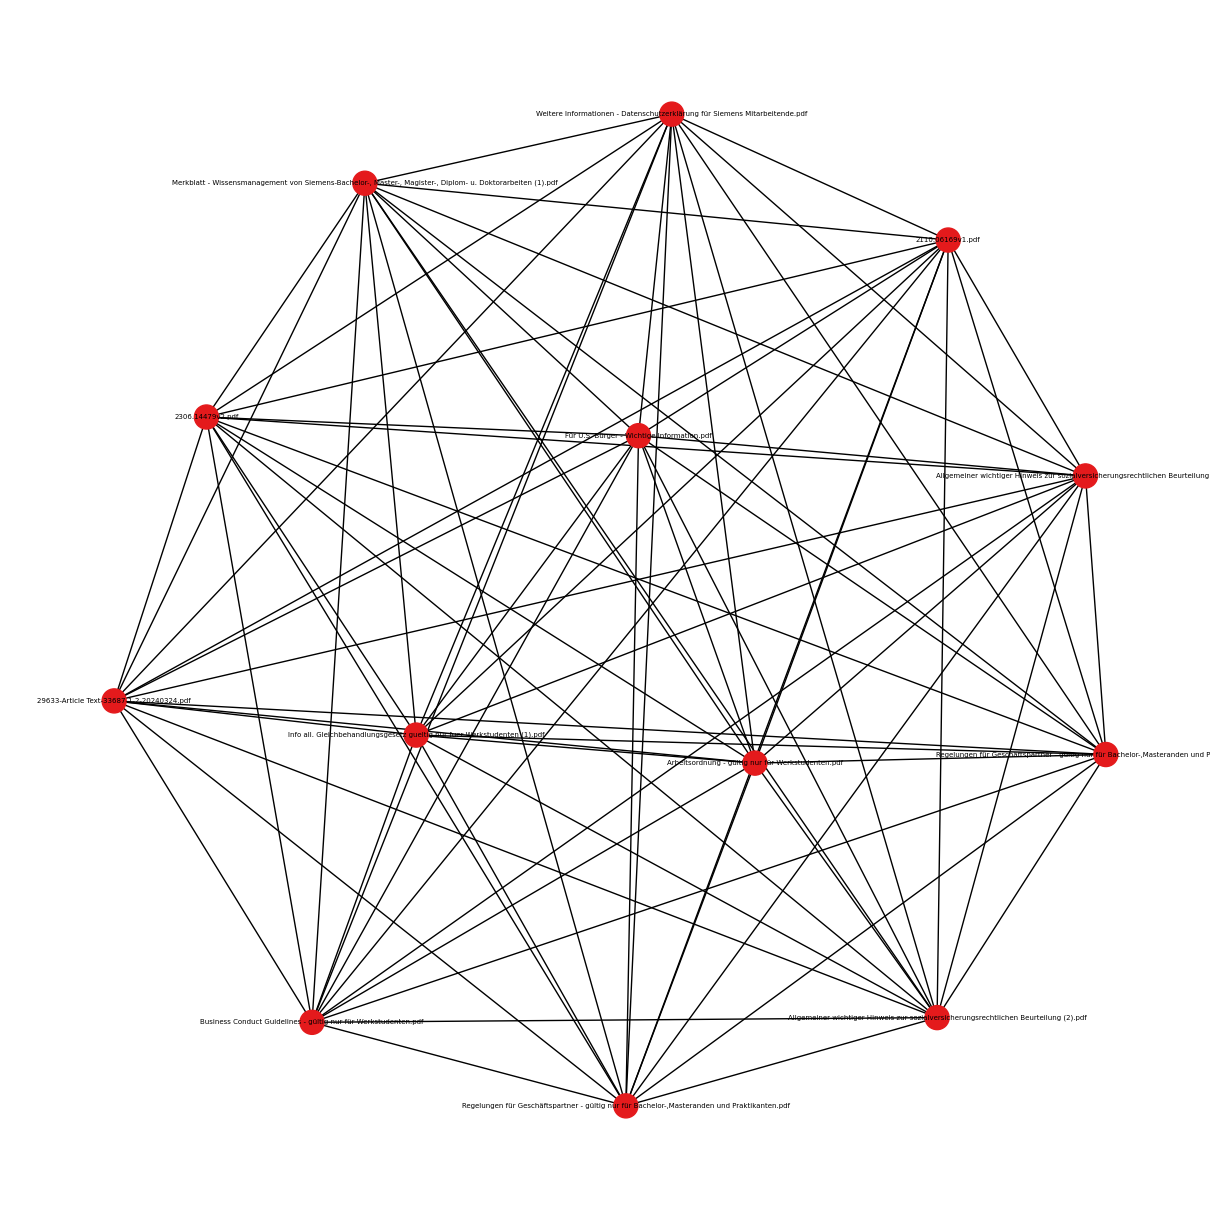

{'2110.06169v1.pdf': [('29633-Article Text-33687-1-2-20240324.pdf', 0.63618565), ('2306.14479v2.pdf', 0.58465916), ('Business Conduct Guidelines - gültig nur für Werkstudenten.pdf', 0.04292509), ('Arbeitsordnung - gültig nur für Werkstudenten.pdf', 0.03689695), ('Für U.S. Bürger - Wichtige Information.pdf', 0.0095861)], 'Regelungen für Geschäftspartner - gültig nur für Bachelor-,Masteranden und Praktikanten (1).pdf': [('Regelungen für Geschäftspartner - gültig nur für Bachelor-,Masteranden und Praktikanten.pdf', 1.0), ('Merkblatt - Wissensmanagement von Siemens-Bachelor-, Master-, Magister-, Diplom- u. Doktorarbeiten (1).pdf', 0.51416504), ('Arbeitsordnung - gültig nur für Werkstudenten.pdf', 0.48166656), ('Info all. Gleichbehandlungsgesetz gueltig nur fuer Werkstudenten (1).pdf', 0.46338683), ('Business Conduct Guidelines - gültig nur für Werkstudenten.pdf', 0.38513333)]}


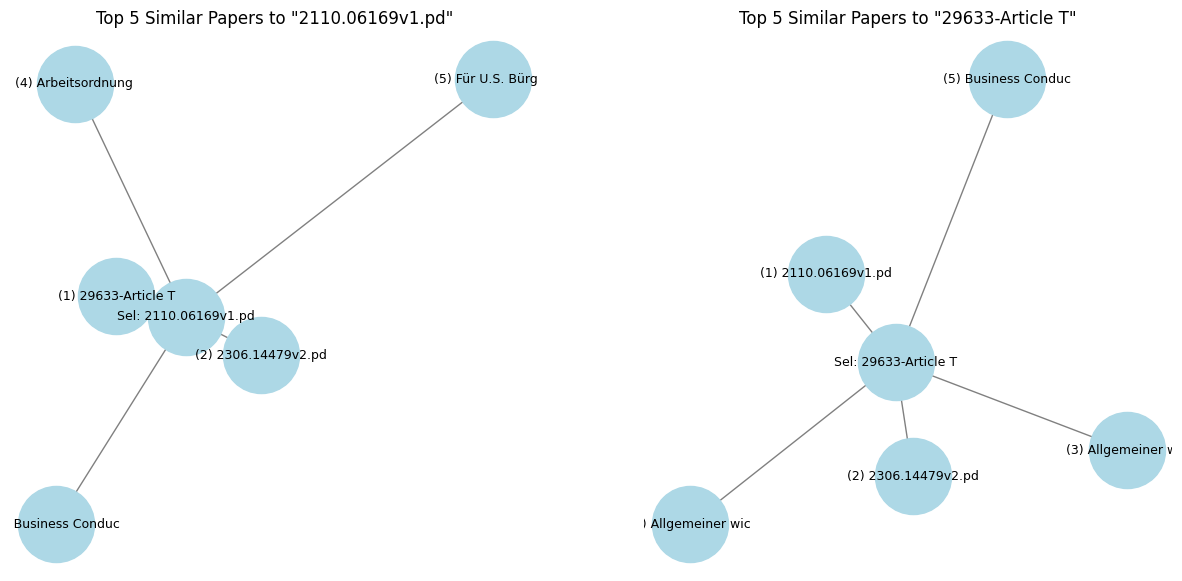

In [23]:
import fitz
import os
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from random import sample

# Assume all PDF files are in a directory called 'papers'
def extract_texts_from_pdfs(directory):
    texts = []
    filenames = []
    for filename in os.listdir(directory):
        if filename.endswith('.pdf'):
            doc = fitz.open(os.path.join(directory, filename))
            text = ""
            for page in doc:
                text += page.get_text()
            texts.append(text)
            filenames.append(filename)
            doc.close()
    return texts, filenames

# load model and extract embeddings
def get_embeddings(texts):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings


def cluster_embeddings_dbscan(embeddings):
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # adjust eps and min_samples based on your dataset
    labels = dbscan.fit_predict(embeddings)
    return labels


def cluster_embeddings_kmeans(embeddings):
    kmeans = KMeans(n_clusters=5, random_state=0)  # adjust the number of clusters as needed
    labels = kmeans.fit_predict(embeddings)
    return labels
def cluster_embeddings_spectral(embeddings):
    spectral = SpectralClustering(n_clusters=5, random_state=0, affinity='nearest_neighbors')
    labels = spectral.fit_predict(embeddings)
    return labels


def cluster_embeddings_gmm(embeddings):
    gmm = GaussianMixture(n_components=5, random_state=0)  # adjust the number of components as needed
    gmm.fit(embeddings)
    labels = gmm.predict(embeddings)
    return labels
def cluster_embeddings_agglomerative(embeddings):
    agglomerative = AgglomerativeClustering(n_clusters=5)  # adjust the number of clusters as needed
    labels = agglomerative.fit_predict(embeddings)
    return labels
def cluster_embeddings_optics(embeddings):
    optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
    labels = optics.fit_predict(embeddings)
    return labels


def visualize_clusters(filenames, labels):
    G = nx.Graph()
    for filename, label in zip(filenames, labels):
        G.add_node(filename, group=label)

    # add edges within the same cluster
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] == labels[j]:
                G.add_edge(filenames[i], filenames[j])

    pos = nx.spring_layout(G)
    colors = [G.nodes[node]['group'] for node in G.nodes()]
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, node_color=colors, with_labels=True, font_size=5, cmap=plt.cm.Set1)
    plt.show()


def find_top_similar_papers(embeddings, filenames):
    # calculate the pairwise cosine similarities
    sim_matrix = cosine_similarity(embeddings)

    # select two random papers
    selected_indices = sample(range(len(filenames)), 2)
    results = {}

    # for each selected paper, find the top 5 most similar papers
    for index in selected_indices:
        # get the indices of the top 6 scores (including itself)
        similar_indices = np.argsort(-sim_matrix[index])[:6]
        
        # remove the paper itself from the list
        top_indices = [i for i in similar_indices if i != index][:5]

        # store the results
        results[filenames[index]] = [(filenames[i], sim_matrix[index][i]) for i in top_indices]

    return results


def find_top_similar_papers_and_plot(embeddings, filenames):
    # calculate the pairwise cosine similarities
    sim_matrix = cosine_similarity(embeddings)

    # select two random papers
    selected_indices = sample(range(len(filenames)), 2)
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # process each selected paper
    for idx, paper_index in enumerate(selected_indices):
        # get the indices of the top 6 scores (including itself)
        similar_indices = np.argsort(-sim_matrix[paper_index])[:6]
        
        # remove the paper itself from the list
        top_indices = [i for i in similar_indices if i != paper_index][:5]

        # create graph
        G = nx.Graph()
        # add edges between the selected paper and the top 5 similar papers
        for rank, i in enumerate(top_indices):
            G.add_edge(filenames[paper_index], filenames[i], weight=sim_matrix[paper_index][i])

        # position nodes with the spring layout
        pos = nx.spring_layout(G)
        
        # draw
        selected_title = filenames[paper_index][:15]  # shorten
        labels = {filenames[paper_index]: f'Sel: {selected_title}'}
        for i, node in enumerate(top_indices, start=1):
            short_title = filenames[node][:15] 
            labels[filenames[node]] = f'({i}) {short_title}'

        nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', edge_color='gray', node_size=3000, font_size=9, ax=axes[idx])
        axes[idx].set_title(f'Top 5 Similar Papers to "{selected_title}"')

    plt.show()

# Main execution
directory = 'papers'
texts, filenames = extract_texts_from_pdfs(directory)
embeddings = get_embeddings(texts)
labels = cluster_embeddings_dbscan(embeddings)
visualize_clusters(filenames, labels)
labels = cluster_embeddings_kmeans(embeddings)
visualize_clusters(filenames, labels)
labels = cluster_embeddings_spectral(embeddings)
visualize_clusters(filenames, labels)

labels = cluster_embeddings_gmm(embeddings)
visualize_clusters(filenames, labels)

labels = cluster_embeddings_agglomerative(embeddings)
visualize_clusters(filenames, labels)

labels = cluster_embeddings_optics(embeddings)
visualize_clusters(filenames, labels)

results = find_top_similar_papers(embeddings, filenames)
print(results)

find_top_similar_papers_and_plot(embeddings, filenames)